## validating image interpolation

In [2]:
from PIL import Image
import os

# Path to the original Zoneplate image
zoneplate_path = '../validation_data/Zoneplate.png'
output_dir = '../validation_data/image_validations'

# Open the grayscale image and convert to RGB
img = Image.open(zoneplate_path).convert('RGB')

# Sizes to test
sizes = [(256, 256), (512, 512), (128, 128)]

# Resize with Lanczos and save
for w, h in sizes:
    resized = img.resize((w, h), resample=Image.LANCZOS)
    out_path = os.path.join(output_dir, f'Zoneplate_{w}x{h}_lanczos_pil.png')
    resized.save(out_path)
    print(f'Saved {out_path}')

# Interpolation modes to test
modes = [
    ("bilinear", Image.BILINEAR),
    ("lanczos", Image.LANCZOS),
    ("nearest", Image.NEAREST),
]

for name, mode in modes:
    resized = img.resize((256, 256), resample=mode)
    out_path = os.path.join(output_dir, f'Zoneplate_256x256_{name}_pil.png')
    resized.save(out_path)
    print(f'Saved {out_path}')

Saved ../validation_data/image_validations/Zoneplate_256x256_lanczos_pil.png
Saved ../validation_data/image_validations/Zoneplate_512x512_lanczos_pil.png
Saved ../validation_data/image_validations/Zoneplate_128x128_lanczos_pil.png
Saved ../validation_data/image_validations/Zoneplate_256x256_bilinear_pil.png
Saved ../validation_data/image_validations/Zoneplate_256x256_lanczos_pil.png
Saved ../validation_data/image_validations/Zoneplate_256x256_nearest_pil.png
Saved ../validation_data/image_validations/Zoneplate_128x128_lanczos_pil.png
Saved ../validation_data/image_validations/Zoneplate_256x256_bilinear_pil.png
Saved ../validation_data/image_validations/Zoneplate_256x256_lanczos_pil.png
Saved ../validation_data/image_validations/Zoneplate_256x256_nearest_pil.png


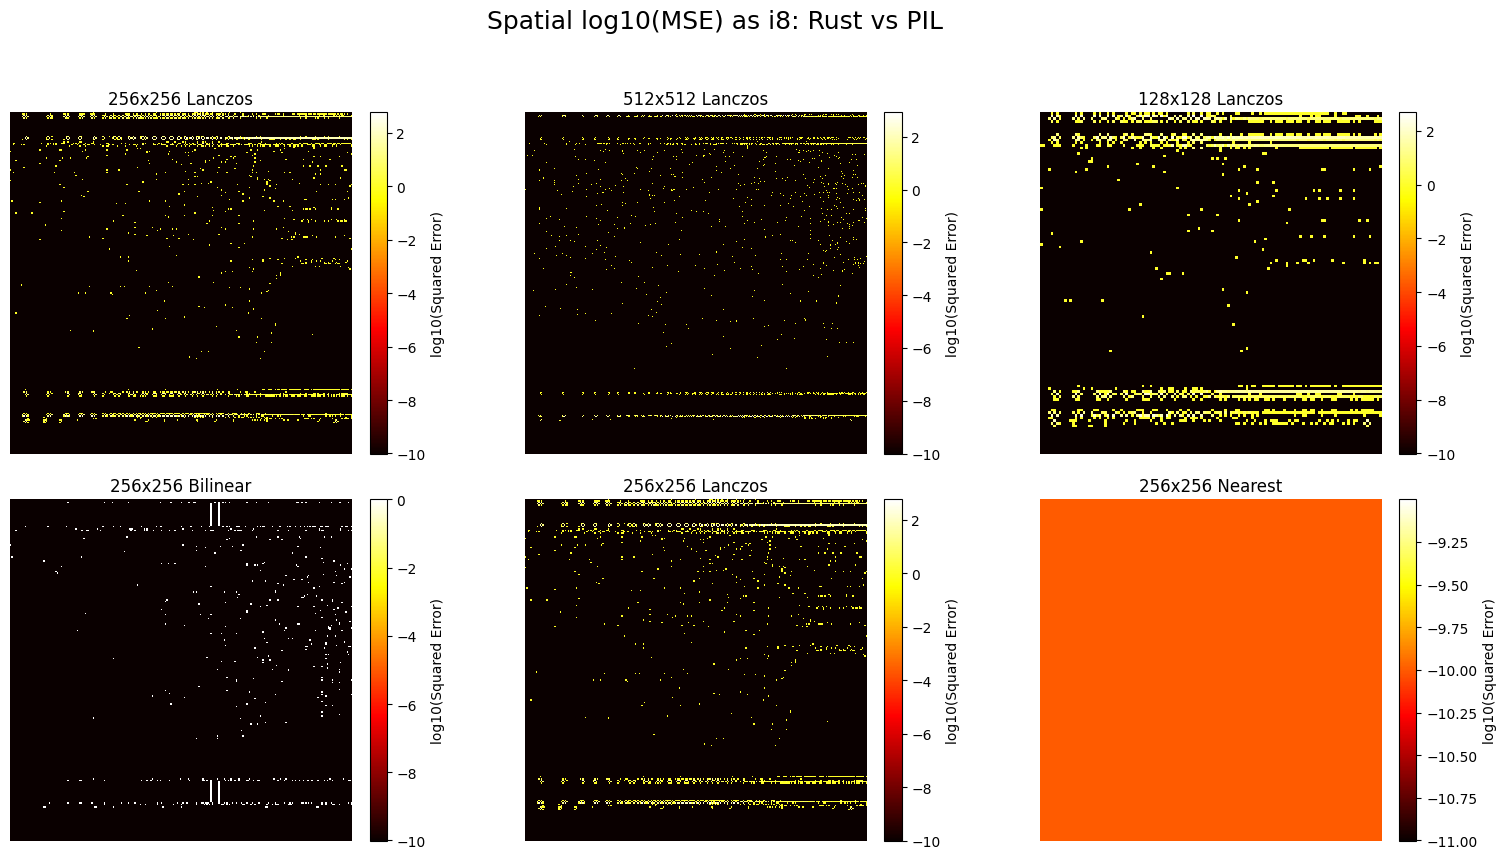

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

# Directory and base name
output_dir = '../validation_data/image_validations'

# List of sizes and modes to compare
sizes = [(256, 256), (512, 512), (128, 128)]
modes = ["bilinear", "lanczos", "nearest"]

# Helper to compute per-pixel squared error (in log space)
def compute_error_image(img1, img2):
    arr1 = np.asarray(img1).astype(np.float32)
    arr2 = np.asarray(img2).astype(np.float32)
    err = (arr1 - arr2) ** 2
    # If RGB, average over channels for visualization
    if err.ndim == 3:
        err = err.mean(axis=2)
    # Use log10 for visualization, add epsilon to avoid log(0)
    err_log = np.log10(err + 1e-10)
    return err_log

# Collect all error images and titles
err_imgs = []
titles = []

# Size-based comparisons
for w, h in sizes:
    rust_path = os.path.join(output_dir, f'Zoneplate_{w}x{h}_lanczos.png')
    pil_path = os.path.join(output_dir, f'Zoneplate_{w}x{h}_lanczos_pil.png')
    if os.path.exists(rust_path) and os.path.exists(pil_path):
        img_rust = Image.open(rust_path).convert('RGB')
        img_pil = Image.open(pil_path).convert('RGB')
        err_img = compute_error_image(img_rust, img_pil)
        err_imgs.append(err_img)
        titles.append(f'{w}x{h} Lanczos')
    else:
        err_imgs.append(None)
        titles.append(f'{w}x{h} Lanczos (missing)')

# Interpolation mode comparisons (256x256)
for mode in modes:
    rust_path = os.path.join(output_dir, f'Zoneplate_256x256_{mode}.png')
    pil_path = os.path.join(output_dir, f'Zoneplate_256x256_{mode}_pil.png')
    if os.path.exists(rust_path) and os.path.exists(pil_path):
        img_rust = Image.open(rust_path).convert('RGB')
        img_pil = Image.open(pil_path).convert('RGB')
        err_img = compute_error_image(img_rust, img_pil)
        err_imgs.append(err_img)
        titles.append(f'256x256 {mode.capitalize()}')
    else:
        err_imgs.append(None)
        titles.append(f'256x256 {mode.capitalize()} (missing)')

# Plot all error images in a 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(16, 9))
for idx, ax in enumerate(axes.flat):
    if idx < len(err_imgs) and err_imgs[idx] is not None:
        im = ax.imshow(err_imgs[idx], cmap='hot', interpolation='nearest')
        ax.set_title(titles[idx])
        ax.axis('off')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='log10(Squared Error)')
    else:
        ax.set_title(titles[idx] if idx < len(titles) else '')
        ax.axis('off')
plt.suptitle('Spatial log10(MSE) as i8: Rust vs PIL', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## validating various layers

In [5]:
# Validate patch embedding output for zeros, ones, and random input using SmolVLM weights
import torch
import numpy as np
from transformers import AutoProcessor, AutoModelForVision2Seq
from safetensors.torch import load_file
import os

In [ ]:
dtype = torch.float32
device = "cpu"

try:
    model = AutoModelForVision2Seq.from_pretrained(
        "HuggingFaceTB/SmolVLM-Instruct",
        # _attn_implementation="flash_attention_2",  # Commented out Flash Attention
        # torch_dtype=torch.bfloat16,
        _attn_implementation="eager",
        torch_dtype=dtype,
        device_map=device,
    )
    model.eval()
except NameError:
    print("Please define or import 'load_smolvlm_model' to load the SmolVLM model.")
    model = None

def zor(layer, shape):
    z = layer(torch.zeros(shape, dtype=dtype, device=device))
    o = layer(torch.ones(shape, dtype=dtype, device=device))
    r = layer(torch.rand(shape, dtype=dtype, device=device))
    return z, o, r

def zor_with_input(layer, zx, ox, rx):
    z = layer(zx)
    o = layer(ox)
    r = layer(rx)
    return z, o, r

# patch_embedding = model.model.vision_model.embeddings.patch_embedding
# shape = (1, 3, 384, 384)
# z, o, r = zor(patch_embedding, shape)
# print("Zeros output shape:", z.shape)
# print("Ones output shape:", o.shape)
# print("Random output shape:", r.shape)

Zeros output shape: torch.Size([1, 1152, 27, 27])
Ones output shape: torch.Size([1, 1152, 27, 27])
Random output shape: torch.Size([1, 1152, 27, 27])


In [7]:
model.model.vision_model

Idefics3VisionTransformer(
  (embeddings): Idefics3VisionEmbeddings(
    (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
    (position_embedding): Embedding(729, 1152)
  )
  (encoder): Idefics3Encoder(
    (layers): ModuleList(
      (0-26): 27 x Idefics3EncoderLayer(
        (self_attn): Idefics3VisionAttention(
          (k_proj): Linear(in_features=1152, out_features=1152, bias=True)
          (v_proj): Linear(in_features=1152, out_features=1152, bias=True)
          (q_proj): Linear(in_features=1152, out_features=1152, bias=True)
          (out_proj): Linear(in_features=1152, out_features=1152, bias=True)
        )
        (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
        (mlp): Idefics3VisionMLP(
          (activation_fn): PytorchGELUTanh()
          (fc1): Linear(in_features=1152, out_features=4304, bias=True)
          (fc2): Linear(in_features=4304, out_features=1152, bias=True)
        )
        (layer_norm2)

In [10]:
# Compare Rust and Python patch embedding outputs using safetensors

# Path to Rust-generated safetensors file
safetensors_path = '../validation_data/image_validations/vision_activations.safetensors'

if not os.path.exists(safetensors_path):
    print(f"Rust safetensors file not found: {safetensors_path}")
else:
    # Load tensors from safetensors file
    tensors = load_file(safetensors_path)
    print(f"Loaded tensors: {list(tensors.keys())}")

    layers = [
        model.model.vision_model.embeddings.patch_embedding,
        model.model.vision_model.post_layernorm,
    ]
    for i in range(27):
        layers.append(model.model.vision_model.encoder.layers[i].layer_norm1)
        layers.append(model.model.vision_model.encoder.layers[i].self_attn.k_proj)
        layers.append(model.model.vision_model.encoder.layers[i].self_attn.q_proj)
        layers.append(model.model.vision_model.encoder.layers[i].self_attn.v_proj)
        layers.append(model.model.vision_model.encoder.layers[i].self_attn.out_proj)
        layers.append(model.model.vision_model.encoder.layers[i].layer_norm2)
        layers.append(model.model.vision_model.encoder.layers[i].mlp.fc1)
        layers.append(model.model.vision_model.encoder.layers[i].mlp.fc2)

    for i, layer_f in enumerate(layers):
        for label in ['z', 'o', 'r']:
            rust_input = tensors[f'{i}_{label}x']  # input to patch embedding
            rust_output = tensors[f'{i}_{label}']  # output from patch embedding

            # Run the same patch embedding in Python
            py_output = layer_f(rust_input)

            # Compute MSE between Rust and Python outputs
            mse = torch.mean((py_output - rust_output) ** 2).item()
            print(f"MSE for input '{label}': {mse:.6e}")

            # Optionally, print max absolute error for more insight
            max_abs_err = torch.max(torch.abs(py_output - rust_output)).item()
            print(f"Max abs error for input '{label}': {max_abs_err:.6e}")

Loaded tensors: ['0_o', '0_ox', '0_r', '0_rx', '0_z', '0_zx', '100_o', '100_ox', '100_r', '100_rx', '100_z', '100_zx', '101_o', '101_ox', '101_r', '101_rx', '101_z', '101_zx', '102_o', '102_ox', '102_r', '102_rx', '102_z', '102_zx', '103_o', '103_ox', '103_r', '103_rx', '103_z', '103_zx', '104_o', '104_ox', '104_r', '104_rx', '104_z', '104_zx', '105_o', '105_ox', '105_r', '105_rx', '105_z', '105_zx', '106_o', '106_ox', '106_r', '106_rx', '106_z', '106_zx', '107_o', '107_ox', '107_r', '107_rx', '107_z', '107_zx', '108_o', '108_ox', '108_r', '108_rx', '108_z', '108_zx', '109_o', '109_ox', '109_r', '109_rx', '109_z', '109_zx', '10_o', '10_ox', '10_r', '10_rx', '10_z', '10_zx', '110_o', '110_ox', '110_r', '110_rx', '110_z', '110_zx', '111_o', '111_ox', '111_r', '111_rx', '111_z', '111_zx', '112_o', '112_ox', '112_r', '112_rx', '112_z', '112_zx', '113_o', '113_ox', '113_r', '113_rx', '113_z', '113_zx', '114_o', '114_ox', '114_r', '114_rx', '114_z', '114_zx', '115_o', '115_ox', '115_r', '115

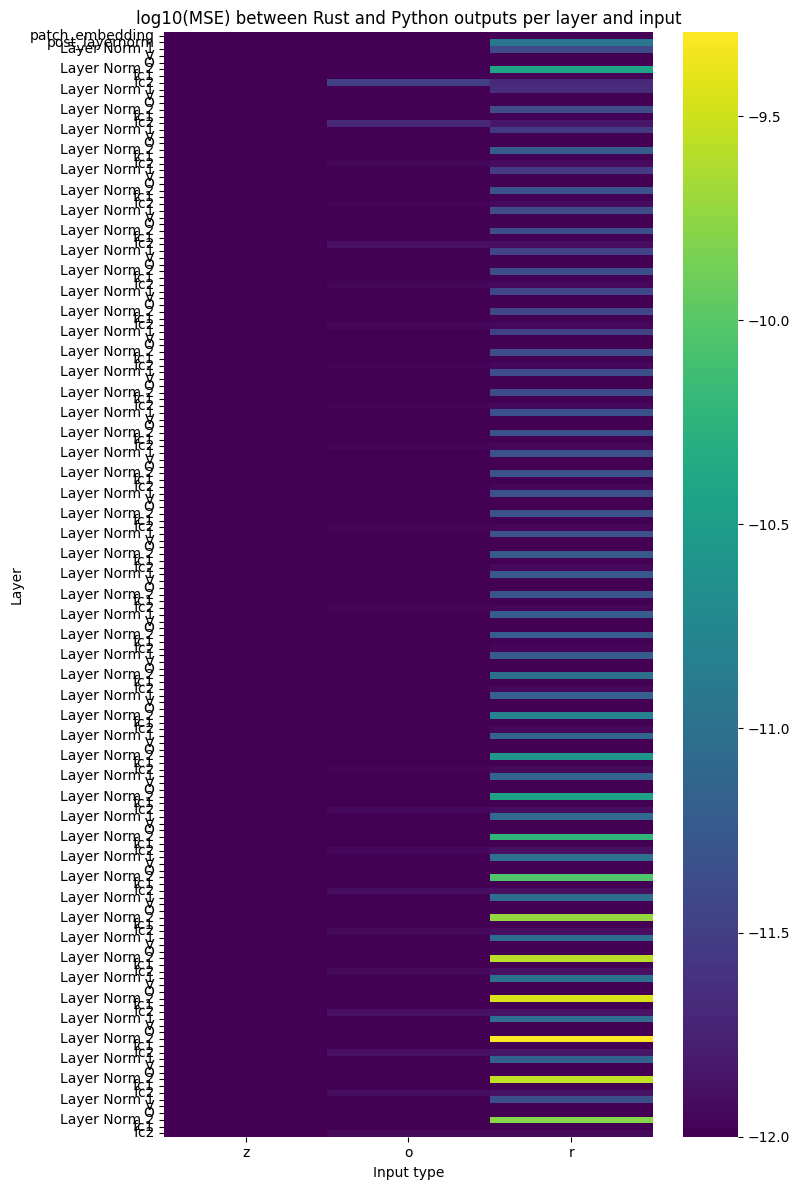

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Prepare layer names and input types
layer_names = []
input_types = ['z', 'o', 'r']

# Re-load tensors and model if needed
safetensors_path = '../validation_data/image_validations/vision_activations.safetensors'
tensors = load_file(safetensors_path)

# Prepare the layers in the same order as above
layers = [model.model.vision_model.embeddings.patch_embedding]
layers.append(model.model.vision_model.post_layernorm)
for i in range(27):
    layers.append(model.model.vision_model.encoder.layers[i].layer_norm1)
    layers.append(model.model.vision_model.encoder.layers[i].self_attn.k_proj)
    layers.append(model.model.vision_model.encoder.layers[i].self_attn.q_proj)
    layers.append(model.model.vision_model.encoder.layers[i].self_attn.v_proj)
    layers.append(model.model.vision_model.encoder.layers[i].self_attn.out_proj)
    layers.append(model.model.vision_model.encoder.layers[i].layer_norm2)
    layers.append(model.model.vision_model.encoder.layers[i].mlp.fc1)
    layers.append(model.model.vision_model.encoder.layers[i].mlp.fc2)


# mse_matrix = np.zeros((len(layers), len(input_types)))
mse_matrix = []
# For each layer, compute MSE for z, o, r
for layer_idx, layer in enumerate(layers):
    # if layer_idx >= 2 and (layer_idx-2)%8 in [1,2]:
    #     continue

    if layer_idx == 0:
        layer_names.append("patch_embedding")
    elif layer_idx == 1:
        layer_names.append("post_layernorm")
    else:
        layer_names.append([
            "Layer Norm 1",
            "K",
            "Q",
            "V",
            "O",
            "Layer Norm 2",
            "fc1",
            "fc2",
        ][(layer_idx-2)%8])
    
    cols = []
    for col_idx, label in enumerate(input_types):
        rust_input = tensors[f'{layer_idx}_{label}x']
        rust_output = tensors[f'{layer_idx}_{label}']
        # If the block is not callable, skip
        try:
            py_output = layer(rust_input)
        except Exception as e:
            mse_matrix[layer_idx, col_idx] = np.nan
            continue

        mse = torch.mean((py_output - rust_output) ** 2).item()
        # mse_matrix[layer_idx, col_idx] = mse
        cols.append(mse)
    mse_matrix.append(cols)
mse_matrix = np.array(mse_matrix)

# Plot heatmap without annotation numbers
plt.figure(figsize=(8, 12))
sns.heatmap(np.log10(mse_matrix + 1e-12), annot=False, cmap="viridis", xticklabels=input_types, yticklabels=layer_names)
plt.xlabel('Input type')
plt.ylabel('Layer')
plt.title('log10(MSE) between Rust and Python outputs per layer and input')
plt.tight_layout()
plt.show()